<h2>Decision Tree</h2>

In this module, we learn to use Decision Tree to solve classification and regression problems

<h3>For Classification</h3>

We start with a simple dataset (I used this one in SVM as well).

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

c:\users\linhl\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\linhl\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [30]:
#create some instances 
X = np.array([
    [1,1],
    [1.5,2],
    [2,1],
    [1.41,1.41],
    [1,2],
    [1,3],
    [3,3],
    [3,5],
    [3.5,2],
    [3.6,3.2],
    [3.1,3.5],
    [2.5,4]
])

Y = np.array([0,0,0,0,0,0,1,1,1,1,1,1])

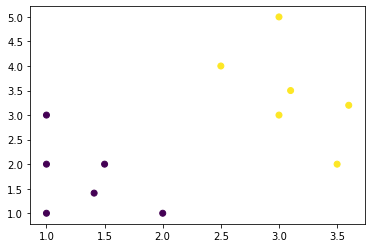

In [31]:
#and visualize them
#colors will represent the two classes in this case
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [32]:
#now fit a decision tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

We can visualize a tree in SKLearn very easily

[Text(167.4, 163.07999999999998, 'X[0] <= 2.25\nsamples = 12\nvalue = [6, 6]'),
 Text(83.7, 54.360000000000014, 'samples = 6\nvalue = [6, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'samples = 6\nvalue = [0, 6]')]

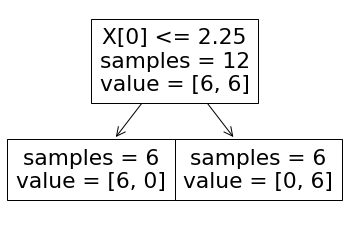

In [33]:
#we use the plot_tree() function from sklearn.tree
from sklearn.tree import plot_tree

#the function takes input as a trained decision tree
plot_tree(dt, impurity=False)  #we set impurity to False to hide the impurity measurements of the nodes
                               #-- since we did not discuss impurity measurements.

<h4> Applied on the Credit Approval Data </h4>

Now let's try decision tree on the credit approval data. As usual, we preprocess the data first

In [37]:
crx = pd.read_csv('crx.data', header=None)
crx.head()

Y = np.zeros(crx.shape[0])           #create a vector of zeros with size = the data
Y[crx[15]=='+'] = 1                  #when the actual target is +, Y is assigned 1
crx[15] = Y  

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(crx, crx[15]):
    strat_train_set = crx.loc[train_index]
    strat_test_set = crx.loc[test_index]
    
trainX = strat_train_set.loc[:,:14]
trainY = strat_train_set.loc[:,15]
trainX.shape, trainY.shape

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_cols = trainX.columns[(trainX.dtypes == np.int64) | (trainX.dtypes == np.float64)]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

#get a list of class columns
cat_cols = trainX.columns[trainX.dtypes==object]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', OneHotEncoder())
])

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)

testX = strat_test_set.loc[:,:14]
testY = strat_test_set.loc[:,15]

testX_prc = full_pipeline.transform(testX)  

Now finetune the tree. Decision tree is actually quite unstable - if you rerun the finetuning below multiple times, you may get different performances.

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [5, 10, 15],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [3, 4, 5, 6],
                         

Best training model:

In [58]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 3, 'max_features': 15, 'min_samples_leaf': 20, 'min_samples_split': 30}
0.8587565347274084


In [59]:
best_dt = grid_search.best_estimator_
best_dt.score(testX_prc, testY)

0.8670520231213873

Let's also visualize the tree. You can see, the tree actually uses only five features from the training data but still acquires a very high accuracy.

[Text(558.0, 332.955, 'X[42] <= 0.5\nsamples = 517\nvalue = [287, 230]'),
 Text(279.0, 237.825, 'X[4] <= -0.555\nsamples = 270\nvalue = [62, 208]'),
 Text(139.5, 142.695, 'X[3] <= -0.395\nsamples = 94\nvalue = [8, 86]'),
 Text(69.75, 47.565, 'samples = 22\nvalue = [7, 15]'),
 Text(209.25, 47.565, 'samples = 72\nvalue = [1, 71]'),
 Text(418.5, 142.695, 'X[44] <= 0.5\nsamples = 176\nvalue = [54, 122]'),
 Text(348.75, 47.565, 'samples = 105\nvalue = [14, 91]'),
 Text(488.25, 47.565, 'samples = 71\nvalue = [40, 31]'),
 Text(837.0, 237.825, 'X[2] <= -0.229\nsamples = 247\nvalue = [225, 22]'),
 Text(697.5, 142.695, 'X[4] <= 0.657\nsamples = 192\nvalue = [179, 13]'),
 Text(627.75, 47.565, 'samples = 157\nvalue = [149, 8]'),
 Text(767.25, 47.565, 'samples = 35\nvalue = [30, 5]'),
 Text(976.5, 142.695, 'X[5] <= -0.188\nsamples = 55\nvalue = [46, 9]'),
 Text(906.75, 47.565, 'samples = 23\nvalue = [16, 7]'),
 Text(1046.25, 47.565, 'samples = 32\nvalue = [30, 2]')]

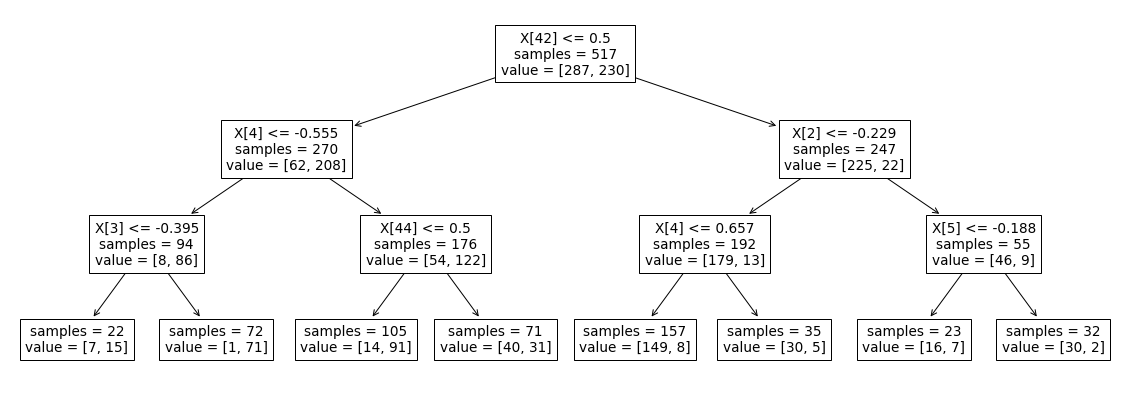

In [60]:
plt.figure(figsize=(20,7)) #setting figure size
plot_tree(best_dt, impurity=False) 

<h4>Summarize all Results</h4>

Compared to other models so far:

|Model|Training CV Accuracy| Testing Accuracy|
|-----|--------------------|-----------------|
|No Regularization|0.834|0.850|
|L2 Regularization|0.857|0.861|
|L1 Regularization|0.861|0.861|
|ENet Regularization|0.863|0.861|
|L1 Linear SVM|0.851|0.861|
|L2 Linear SVM|0.853|0.873|
|Kernel SVM|0.872|0.867|
|Decision Tree|0.858|0.867|

As you can see, decision tree' performance is quite good while using very low number of features.

<h3> For Regression </h3>

Decision tree also works for regression tasks. We will use DecisionTreeRegressor instead. Let's revisit the auto-mpg data

In [61]:
auto = pd.read_csv('auto-mpg.csv')

from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(auto):
    train_set = auto.loc[train_index]
    test_set = auto.loc[test_index]
    
trainX = train_set.drop('mpg',axis=1)
trainY = train_set['mpg']
testX = test_set.drop('mpg',axis=1)
testY = test_set['mpg']

trainX.shape, testX.shape, trainY.shape, testY.shape

((298, 7), (100, 7), (298,), (100,))

In [63]:
#pipeline for numeric features
#we need to impute horsepower
num_cols = trainX.columns[:-1] #because the last column is class
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

#pipeline for class features
cat_cols = trainX.columns[-1:] #because the last column is class
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

#full pipeline - combine numeric and class pipelines
full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)
testX_prc = full_pipeline.transform(testX)

trainX_prc.shape

(298, 9)

In [73]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [5, 7, 9],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [5, 7, 9],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
        

In [74]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}
0.8226408284573348


In [75]:
best_dt = grid_search.best_estimator_
best_dt.score(testX_prc, testY)

0.8665069075280036

You can also visualize the tree if you like. I would leave that for practice. Finally, we can summarize the results of all models so far

|Model|Training CV R2| Testing R2|
|-----|--------------|-----------|
|Ridge|0.852         |0.893      |
|LASSO|0.851         |0.895      |
|ENet |0.851         |0.895      |
|SVR  |0.864         |0.905      |
|DTR  |0.823         |0.867      |

In this data, decision tree is not a very good model. Its performance is the lowest in both CV training and testing.

In general, decision tree can be very powerful, but also more difficult to use because of the overfitting and stability problem. For that reason, we usually prefer random forest models.